In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocess import get_audio_metadata
os.environ["PYTHONPATH"]="./src"

location = "./SpeakNow_test_data.csv"
speaknow = pd.read_csv(location)

metadata = get_audio_metadata(location)

In [4]:
from fluency import FluencyEvaluator
from pronunciation import PronunciationEvaluator
from vocabulary import VocabularyEvaluator

In [5]:
fluency_scores, fluency_confidences = FluencyEvaluator()(
    metadata.file_name.values.tolist(),
    metadata.assessment_id.values.tolist(),
    score_type='argmax',
    confidence_type='entropy'
)
pronunciation_scores, pronunciation_confidences = PronunciationEvaluator()(
    metadata.file_name.values.tolist(),
    metadata.assessment_id.values.tolist(),
    score_type='argmax',
    confidence_type='entropy'
)
vocabulary_scores, vocabulary_confidences = VocabularyEvaluator()(
    metadata.file_name.values.tolist(),
    metadata.assessment_id.values.tolist(),
    score_type='argmax',
    confidence_type='entropy'
)

In [16]:
speaknow_fluency = dict()
speaknow_pronunciation = dict()
speaknow_vocabulary = dict()

for id in fluency_scores:
    fluency_scores[id] = np.sum(np.array(fluency_scores[id])*np.array(fluency_confidences[id])) / np.sum(np.array(fluency_confidences[id]))
    pronunciation_scores[id] = np.sum(np.array(pronunciation_scores[id])*np.array(pronunciation_confidences[id])) / np.sum(np.array(pronunciation_confidences[id]))
    vocabulary_scores[id] = np.sum(np.array(vocabulary_scores[id])*np.array(vocabulary_confidences[id])) / np.sum(np.array(vocabulary_confidences[id]))

    fluency_confidences[id] = np.max(fluency_confidences[id])
    pronunciation_confidences[id] = np.max(pronunciation_confidences[id])
    vocabulary_confidences[id] = np.max(vocabulary_confidences[id])

    speaknow_fluency[id] = speaknow[speaknow['assessment_id'] == id]['fluency_avg'].values[0]
    speaknow_pronunciation[id] = speaknow[speaknow['assessment_id'] == id]['pronunciation_avg'].values[0]
    speaknow_vocabulary[id] = speaknow[speaknow['assessment_id'] == id]['vocab_avg'].values[0]

results = pd.DataFrame({
    'speaknow_fluency': list(speaknow_fluency.values()),
    'model_fluency': list(fluency_scores.values()),
    'speaknow_pronunciation': list(speaknow_pronunciation.values()),
    'model_pronunciation': list(pronunciation_scores.values()),
    'speaknow_vocabulary': list(speaknow_vocabulary.values()),
    'model_vocabulary': list(vocabulary_scores.values()),
}, index=list(speaknow_fluency.keys()))

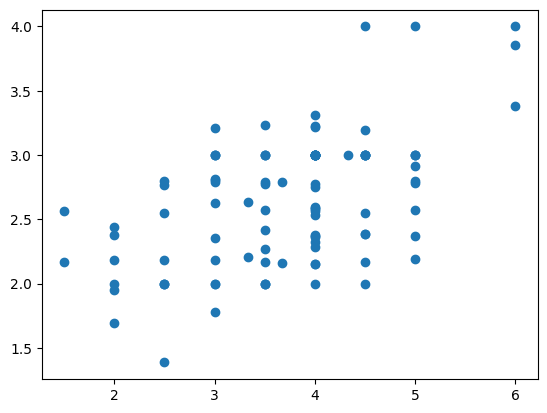

In [24]:
_ = plt.scatter(speaknow_fluency.values(), fluency_scores.values())

In [29]:
results[results['speaknow_fluency'] == 2.5][['speaknow_fluency','model_fluency']].sort_values('model_fluency')

,speaknow_fluency,model_fluency
1692747394818154,2.5,1.387096
1691402791754221,2.5,2.000000
1691402791754497,2.5,2.000000
1692747394818610,2.5,2.000000
1685977329668592,2.5,2.181419
1685651809260972,2.5,2.549336
1693181003292353,2.5,2.765746
1691402791754686,2.5,2.799496


In [34]:
from IPython.display import Audio

# Model Score | SpeakNow Score

# Pronunciation
# Audio('./data/1679466431414415-1.mp3')  # 3.3 | 6.0
# Audio('./data/1659856072110825-1.mp3')  # 4.6 | 5.5
# Audio('./data/1691402791754115-1.mp3')  # 2.2 | 3.5
# Audio('./data/1692751298358510-1.mp3')  # 4.0 | 3.5

# Fluency
# Audio('./data/1679466431414415-1.mp3')  # 3.8 | 6.0
# Audio('./data/1692748253740131-1.mp3')  # 4.0 | 6.0
# Audio('./data/1692849194520981-1.mp3')  # 2.2 | 5.0
# Audio('./data/1692747394818154-1.mp3')  # 1.9 | 2.5
# Audio('./data/1691402791754686-1.mp3')  # 2.8 | 2.5


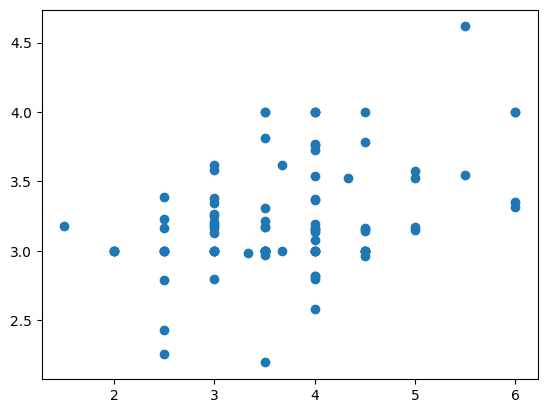

In [15]:
_ = plt.scatter(speaknow_pronunciation.values(), pronunciation_scores.values())

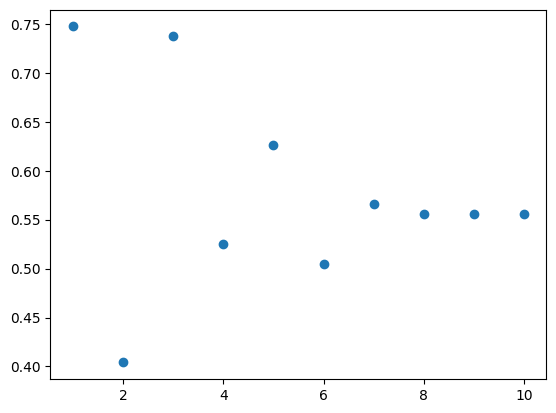

In [41]:
import glob
import json

epochs = []
losses = []
accuracies = []
for state in glob.glob('./whisper-medium-vocabulary-accuracy/checkpoint*/trainer_state.json'):
    train_data = json.load(open(state, 'rb'))
    epochs.append(train_data['log_history'][-1]['epoch'])
    losses.append(train_data['log_history'][-1]['eval_loss'])
    accuracies.append(train_data['log_history'][-1]['eval_accuracy'])

# _ = plt.scatter(epochs, losses)
_ = plt.scatter(epochs, accuracies)

In [47]:
vocabulary_scores_train, vocabulary_confidences_train = VocabularyEvaluator()(
    metadata.file_name.values.tolist()[:-99],
    metadata.assessment_id.values.tolist()[:-99],
    score_type='argmax',
    confidence_type='entropy'
)
vocabulary_scores_validate, vocabulary_confidences_validate = VocabularyEvaluator()(
    metadata.file_name.values.tolist()[-99:],
    metadata.assessment_id.values.tolist()[-99:],
    score_type='argmax',
    confidence_type='entropy'
)

In [43]:
speaknow_vocabulary_train = dict()
for id in vocabulary_scores_train:
    vocabulary_scores_train[id] = np.sum(np.array(vocabulary_scores_train[id])*np.array(vocabulary_confidences_train[id])) / np.sum(np.array(vocabulary_confidences_train[id]))
    vocabulary_confidences_train[id] = np.max(vocabulary_confidences_train[id])
    speaknow_vocabulary_train[id] = speaknow[speaknow['assessment_id'] == id]['vocab_avg'].values[0]

speaknow_vocabulary_validate = dict()
for id in vocabulary_scores_validate:
    vocabulary_scores_validate[id] = np.sum(np.array(vocabulary_scores_validate[id])*np.array(vocabulary_confidences_validate[id])) / np.sum(np.array(vocabulary_confidences_validate[id]))
    vocabulary_confidences_validate[id] = np.max(vocabulary_confidences_validate[id])
    speaknow_vocabulary_validate[id] = speaknow[speaknow['assessment_id'] == id]['vocab_avg'].values[0]

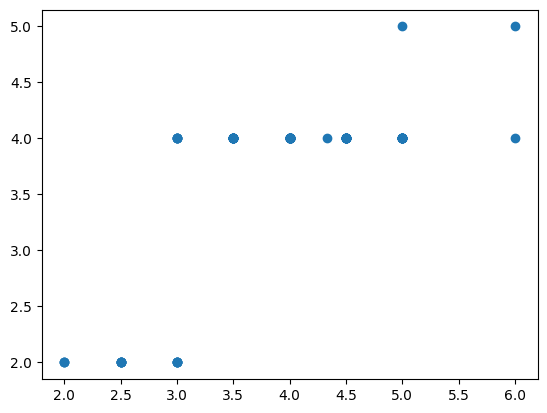

In [51]:
# _ = plt.scatter(speaknow_vocabulary_train.values(), vocabulary_scores_train.values())
_ = plt.scatter(speaknow_vocabulary_validate.values(), vocabulary_scores_validate.values())